### BrainBERT for Synthetic EEG dataset
#### In this notebook, the full pipeline is: load data -> concat data -> preprocessing data (resample + STFT) -> load model and checkpoint-> extract embeddings -> visualize
##### BrainBERT on synthetic: 
1. Only apply BrainBERT to the first channel of concated EEG data. (the pretrained BrainBERT model accepts single-channel spectral inputs)
2. I also tried averaging embeddings across channels, but this largely smoothed out the representations and made label-related patterns difficult to observe. 
3. Future work may explore explicit spatial modeling or attention-based channel fusion to better preserve multi-channel information.

In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import torch

In [2]:
cwd = Path.cwd()
root = cwd.parent.parent
data_dir = root / "data" / "synthetic_eeg"

f1 = data_dir / "neural_data_label1_1.npy"
f2 = data_dir / "neural_data_label2_1.npy"
f3 = data_dir / "neural_data_label3_1.npy"

x1 = np.load(f1)  # (151,27)
x2 = np.load(f2)  # (151,27)
x3 = np.load(f3)  # (151,27)

X = np.concatenate([x1, x2, x3], axis=0)  # (453,27)
print("X shape:", X.shape)

y_point = np.concatenate([
    np.zeros(len(x1), dtype=int),         # label 0
    np.ones(len(x2), dtype=int),          # label 1
    np.full(len(x3), 2, dtype=int)        # label 2
])
print("y_point shape:", y_point.shape)

X shape: (453, 27)
y_point shape: (453,)


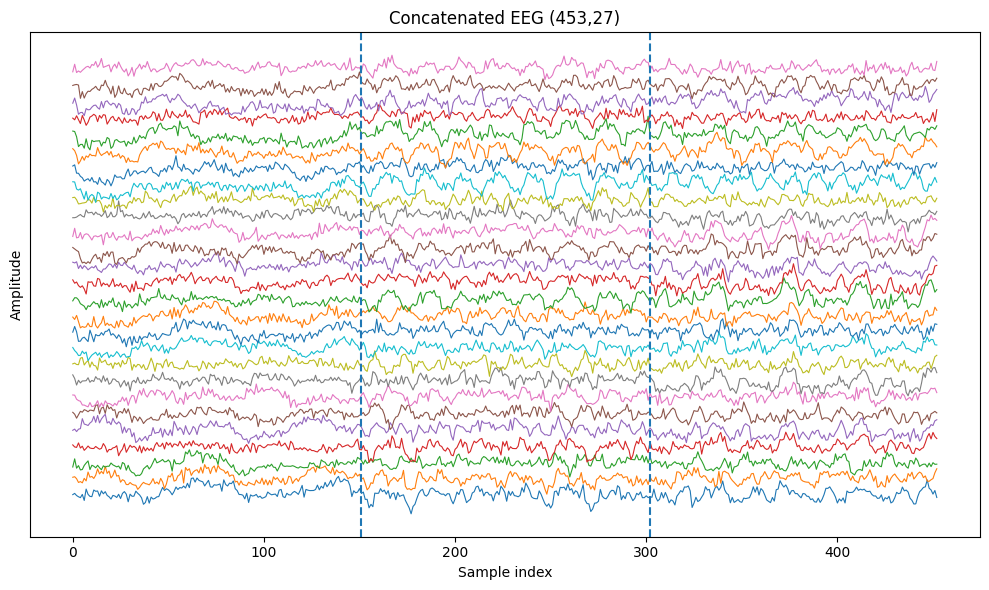

In [3]:
import matplotlib.pyplot as plt

t = np.arange(X.shape[0])
plt.figure(figsize=(10, 6))

offset = 3.0 * np.std(X)
for ch in range(X.shape[1]):
    plt.plot(t, X[:, ch] + ch * offset, linewidth=0.8)

plt.axvline(151, linestyle="--")
plt.axvline(302, linestyle="--")

plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("Concatenated EEG (453,27)")
plt.yticks([])
plt.tight_layout()
plt.show()

In [11]:
brainbert_root = root / "BrainBERT"
if str(brainbert_root) not in sys.path:
    sys.path.insert(0, str(brainbert_root))

print("BrainBERT root:", brainbert_root)
import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = root / "pretrained_weights" / "stft_large_pretrained.pth"
print("CKPT:", ckpt_path)

BrainBERT root: f:\TUD\Phd_application\Oulu\Code\BrainBERT
CKPT: f:\TUD\Phd_application\Oulu\Code\pretrained_weights\stft_large_pretrained.pth


In [ ]:
import numpy as np
import torch
from scipy import signal

def resample_to_length(wav_1d, target_len=2048):
    wav_1d = wav_1d.astype(np.float32)
    if len(wav_1d) == target_len:
        return wav_1d
    return signal.resample(wav_1d, target_len).astype(np.float32)

def safe_zscore(x, axis=-1, eps=1e-6):
    mean = np.mean(x, axis=axis, keepdims=True)
    std  = np.std(x, axis=axis, keepdims=True)
    std = np.where(std < eps, 1.0, std)
    return (x - mean) / std

def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5

    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = safe_zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip] + 1e-8)
        t = t[clip:-clip]

    Zxx = np.nan_to_num(Zxx, nan=0.0, posinf=0.0, neginf=0.0)
    return f, t, Zxx

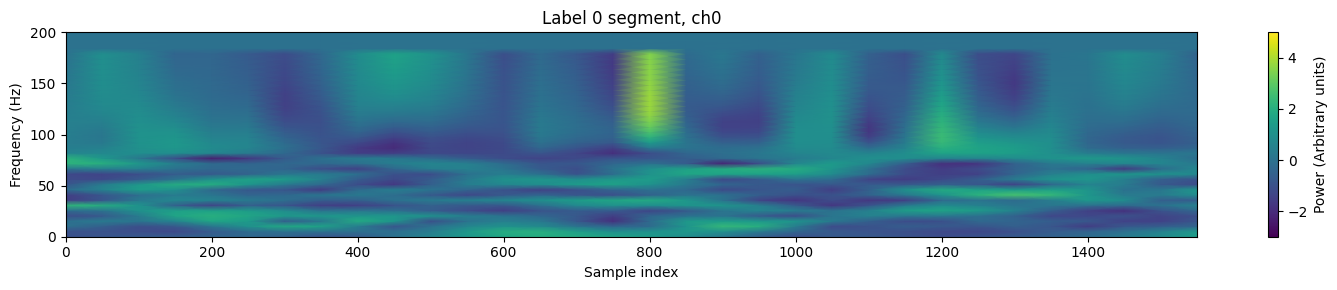

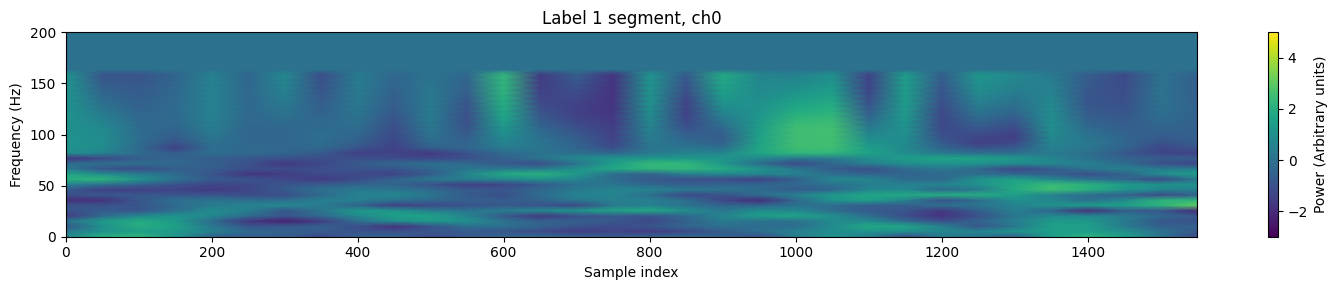

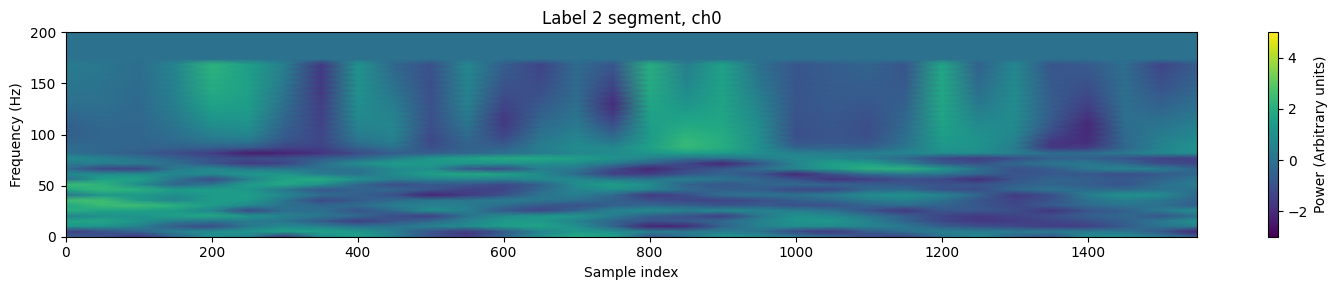

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stft_from_1d(wav_1d, title="STFT (BrainBERT style)"):
    wav = resample_to_length(wav_1d, target_len=2048)
    nperseg = 400
    noverlap = 350
    hop = nperseg - noverlap
    f, t, linear = get_stft(
        wav, 2048,
        clip_fs=40,
        nperseg=nperseg,
        noverlap=noverlap,
        normalizing="zscore",
        return_onesided=True
    )
    x_samples = np.arange(linear.shape[1]) * hop
    plt.figure(figsize=(15, 3))
    f = f.copy()
    f[-1] = 200
    g = plt.pcolormesh(
        x_samples,
        f,
        linear,
        shading="gouraud",
        vmin=-3,
        vmax=5
    )
    cbar = plt.colorbar(g)
    cbar.ax.set_ylabel("Power (Arbitrary units)")
    plt.xlabel("Sample index")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_stft_from_1d(x1[:, 0], title="Label 0 segment, ch0")
plot_stft_from_1d(x2[:, 0], title="Label 1 segment, ch0")
plot_stft_from_1d(x3[:, 0], title="Label 2 segment, ch0")

In [14]:
def build_model(ckpt_path, device):
    init_state = torch.load(ckpt_path, map_location="cpu")

    model_cfg = init_state["model_cfg"]

    model = models.build_model(model_cfg)
    model.load_weights(init_state["model"])
    model.to(device)
    model.eval()

    return model

model = build_model(ckpt_path, device)
print("BrainBERT model loaded.")

d:\Anaconda3\envs\brainbert\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


BrainBERT model loaded.


In [ ]:
@torch.no_grad()
def brainbert_out_one_channel(model, wav_1d, device, target_len=2048):
    wav = resample_to_length(wav_1d, target_len=target_len)

    _, _, linear = get_stft(
        wav, 2048,
        clip_fs=40,
        nperseg=400,
        noverlap=350,
        normalizing="zscore",
        return_onesided=True
    )

    inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to(device)  # (1, ts, 40)
    mask = torch.zeros(inputs.shape[:2], dtype=torch.bool, device=device)

    with torch.no_grad():
        out = model.forward(inputs, mask, intermediate_rep=True)  # (1, ts, D)
    return out

def plot_brainbert_official(out, title="BrainBERT Feature Representation"):
    output_features = out.squeeze(0).cpu().numpy()  # (ts, D)

    plt.figure(figsize=(10, 6))
    plt.imshow(output_features.T, aspect="auto", cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Activation")
    plt.xlabel("Time Steps (STFT frames)")
    plt.ylabel("Feature Dimension")
    plt.title(title)
    plt.tight_layout()
    plt.show()

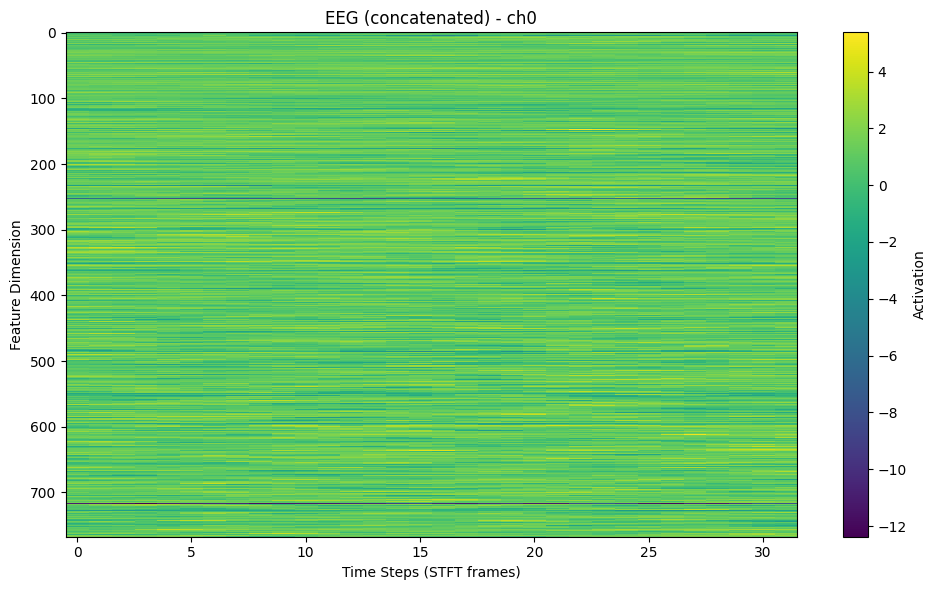

In [36]:
wav_all = X[:, 0].astype(np.float32)

out_all = brainbert_out_one_channel(model, wav_all, device, target_len=2048)
plot_brainbert_official(out_all, title="EEG (concatenated) - ch0")